In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
from src.preprocessing.computer_vision import augmentation, scaling
from src.projects.eurosat.architecture import FCNNetwork, CNNNetwork

2022-12-02 13:30:35.973854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 13:30:36.851470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 13:30:36.851676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 13:30:36.851687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

In [2]:
_log = getLogger()
model_save_fp = Path(os.getcwd()) / Path('trained_models') / Path('eurosat')

In [3]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    "eurosat/rgb", as_supervised=True, split=["train[:80%]", "train[80%:90%]", "train[90%:]"]
)
_, info = tfds.load(
    "eurosat/rgb", as_supervised=True, with_info=True,
)

In [4]:
# Labels
class_names = info.features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Plotting some random images with their label

In [5]:
def plot_random_images(dataset: tf.data.Dataset, sample_size :int):
    random_images = []
    sqrt_sample = int(np.sqrt(sample_size))

    for el in dataset.shuffle(1000).take(sqrt_sample*sqrt_sample):
        image, label = el
        label_name = class_names[label.numpy()]
        random_images.append((label_name, image))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img_tuple, ax in zip(random_images, axs.ravel()):
        label, img = img_tuple
        ax.imshow(img)
        ax.set_title(label)
    plt.show()


2022-12-02 13:30:43.722570: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


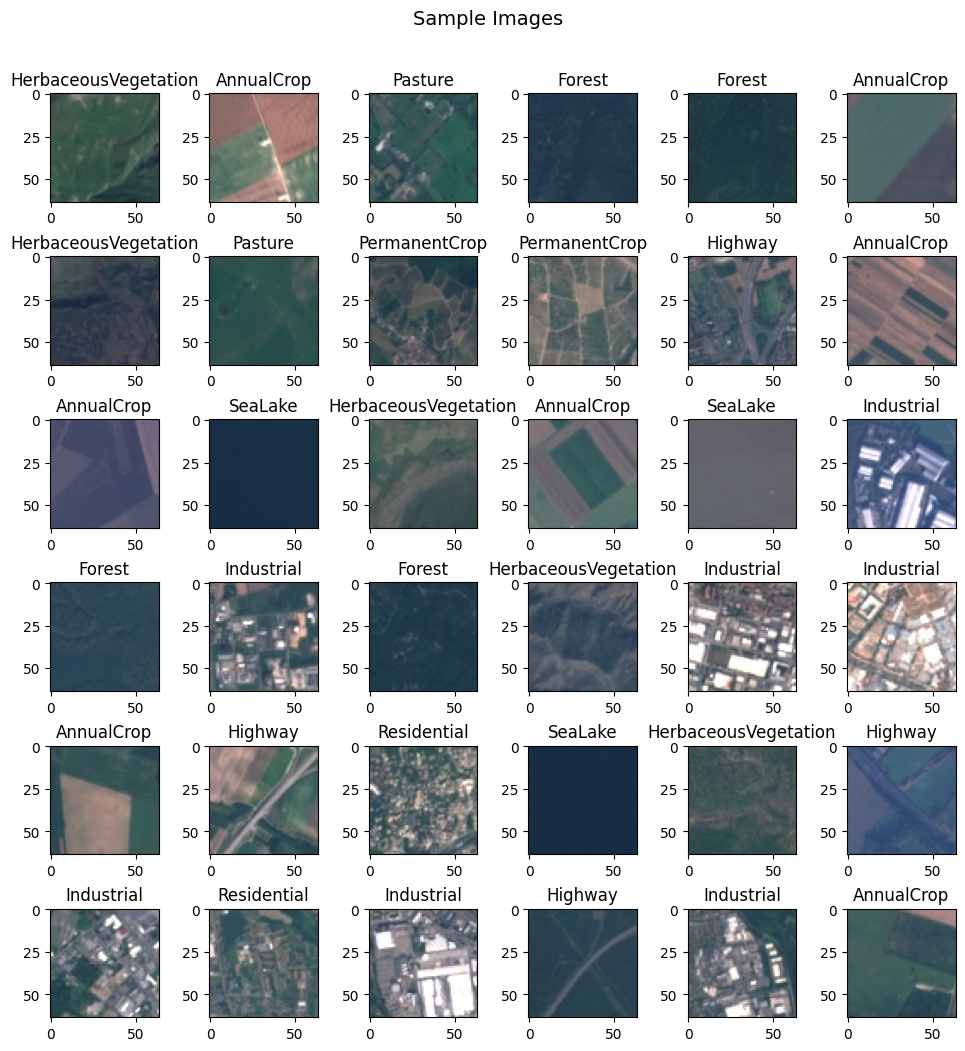

In [6]:
plot_random_images(train_dataset, 36)

The next steps will be about preprocessing the images: we will randomly flip them, adjust the brightness and the contrast. Since all images have the same size we don't need to crop or resize them

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2022-12-02 13:30:47.848607: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


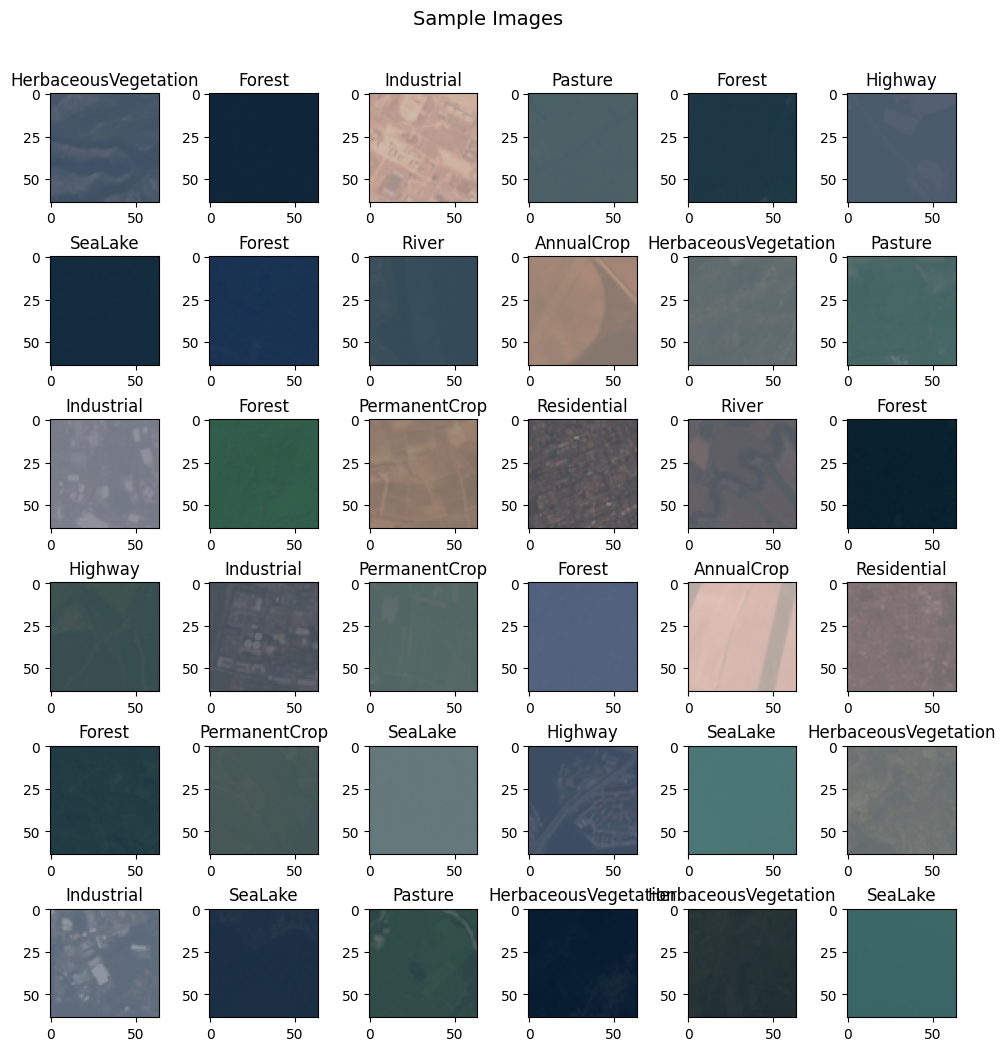

In [7]:
train_dataset = train_dataset.map(lambda image, label: (augmentation(image), label))
plot_random_images(train_dataset, 36)
train_dataset = train_dataset.map(lambda image, label: (scaling(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (augmentation(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (scaling(image), label))

In [8]:
batch_size = 32
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
name = 'CNNNetwork'
artifacts_path = model_save_fp / Path(name)
model = CNNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    #callbacks=callbacks(),
    steps_per_epoch=600,
    validation_steps=600,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Model: "CNNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       9728      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                        

2022-12-02 13:10:40.403409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inCNNNetwork/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-02 13:10:41.615120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-02 13:10:42.319142: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 13:10:43.101235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-02 13:10:43.104590: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efbdc014aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-02 13:10:43.104626: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor devi

600/600 [==============================] - 18s 21ms/step - loss: 22.0301 - accuracy: 0.2544 - val_loss: 6.3682 - val_accuracy: 0.2666 - lr: 0.0010
Epoch 2/100
600/600 [==============================] - 12s 21ms/step - loss: 3.9762 - accuracy: 0.3391 - val_loss: 1.9596 - val_accuracy: 0.3430 - lr: 0.0010
Epoch 3/100
600/600 [==============================] - 12s 21ms/step - loss: 1.7711 - accuracy: 0.4067 - val_loss: 1.4800 - val_accuracy: 0.4598 - lr: 0.0010
Epoch 4/100
600/600 [==============================] - 12s 20ms/step - loss: 1.5953 - accuracy: 0.4307 - val_loss: 1.4491 - val_accuracy: 0.4665 - lr: 0.0010
Epoch 5/100
600/600 [==============================] - 12s 20ms/step - loss: 1.5410 - accuracy: 0.4501 - val_loss: 1.4430 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 6/100
600/600 [==============================] - 12s 21ms/step - loss: 1.5631 - accuracy: 0.4489 - val_loss: 1.4924 - val_accuracy: 0.4468 - lr: 0.0010
Epoch 7/100
600/600 [==============================] - 12s 20ms

INFO:tensorflow:Assets written to: /home/deeplearning/trained_models/eurosat/CNNNetwork/assets


INFO:tensorflow:Assets written to: /home/deeplearning/trained_models/eurosat/CNNNetwork/assets


In [9]:
name = 'FCNNetwork'
artifacts_path = model_save_fp / Path(name)
model = FCNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    #callbacks=callbacks(),
    steps_per_epoch=600,
    validation_steps=600,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Model: "FCNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 128)   9728      
                                                                 
 batch_normalization (BatchN  (None, None, None, 128)  512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, None, 128)   0         
                                                                 
 dropout (Dropout)           (None, None, None, 128)   0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 256)   295168    
                                                        

2022-12-02 13:31:02.085583: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inFCNNetwork/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-12-02 13:31:03.225186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-02 13:31:03.949237: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 13:31:04.686773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-02 13:31:04.691112: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7e48019b60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-02 13:31:04.691133: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor devi

600/600 [==============================] - ETA: 0s - loss: 1.6615 - accuracy: 0.3908

2022-12-02 13:31:15.334635: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A5000" frequency: 1695 num_cores: 64 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23413260288 bandwidth: 768096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


600/600 [==============================] - 18s 22ms/step - loss: 1.6615 - accuracy: 0.3908 - val_loss: 1.7258 - val_accuracy: 0.3321
Epoch 2/100
600/600 [==============================] - 13s 22ms/step - loss: 1.5310 - accuracy: 0.4437 - val_loss: 1.8703 - val_accuracy: 0.3290
Epoch 3/100
600/600 [==============================] - 13s 22ms/step - loss: 1.4829 - accuracy: 0.4605 - val_loss: 1.7286 - val_accuracy: 0.3724
Epoch 4/100
600/600 [==============================] - 13s 22ms/step - loss: 1.4237 - accuracy: 0.4884 - val_loss: 1.6562 - val_accuracy: 0.4127
Epoch 5/100
600/600 [==============================] - 13s 22ms/step - loss: 1.3744 - accuracy: 0.5105 - val_loss: 1.6208 - val_accuracy: 0.4598
Epoch 6/100
600/600 [==============================] - 13s 21ms/step - loss: 1.3181 - accuracy: 0.5280 - val_loss: 1.5363 - val_accuracy: 0.4706
Epoch 7/100
600/600 [==============================] - 12s 21ms/step - loss: 1.2945 - accuracy: 0.5428 - val_loss: 1.3405 - val_accuracy: 0.53